In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import project_path
from project_path import (
    module_path,
    configuration_dir, 
    data_dir, 
    report_dir,
    model_dir
)
from shorelineforecasting.utils.configs import GluonConfigs

In [2]:
tf = GluonConfigs.load_data()
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [3]:
sites = pd.read_csv("/media/storage/data/shorelines/sites-gluonts-prepared-37k.csv")
sites = sites.loc[sites['transect_id'].isin(tf.index)]
print(f"Transects included in dataset: {sites.shape[0]}; metadata columns: {sites.shape[1]}")
sites.head()

Transects included in dataset: 37111; metadata columns: 27


,transect_id,country_id,continent,country_name,changerate,changerate_unc,flag_sandy,no_shorelines,RMSE,Timespan,...,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,coastline_idint,geometry,dbscan_cluster,fcluster,optics_clusters
0,BOX_051_170_3,ARG,South America,Argentina,0.389332,0.344834,True,33.0,18.281954,32.0,...,-36.378387,-56.709120,-36.376892,-56.700333,-36.375397,7427,POINT (-56.70912170410156 -36.37689208984375),0,2455,0
1,BOX_051_170_4,ARG,South America,Argentina,0.501007,0.390176,True,33.0,20.685827,32.0,...,-36.374847,-56.710050,-36.373356,-56.701260,-36.371860,7427,POINT (-56.71004867553711 -36.37335586547852),0,2455,0
2,BOX_051_170_5,ARG,South America,Argentina,0.831012,0.331491,True,33.0,17.574545,32.0,...,-36.371933,-56.711193,-36.369860,-56.702587,-36.367786,7427,POINT (-56.7111930847168 -36.3698616027832),0,2455,0
3,BOX_051_170_6,ARG,South America,Argentina,1.471142,0.277497,True,33.0,14.711926,32.0,...,-36.368470,-56.712482,-36.366394,-56.703876,-36.364323,7427,POINT (-56.71248245239258 -36.36639404296875),0,2455,0
4,BOX_051_170_7,ARG,South America,Argentina,2.159336,0.288062,True,33.0,15.272047,32.0,...,-36.365000,-56.713768,-36.362930,-56.705162,-36.360855,7427,POINT (-56.71376800537109 -36.36293029785156),0,2455,0


In [4]:
metadata = {
    'num_series': len(tf),
    'num_steps': len(tf.columns),
    'prediction_length': 7,
    'freq': "AS",
    'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
    'item_id': tf.index.values,
    'epochs': 10,
    'save_model': True,
    'evaluate_model': True,
}

In [5]:
from sklearn import preprocessing


transformations = {
    "standarize": preprocessing.StandardScaler(),
    "min-max-scale": preprocessing.MinMaxScaler()
}

rebase = lambda x: x-x[0]

def scale_df(df, method):
    x = df.values
    scaler = transformations[method]
    x_scaled = scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index=df.index, columns=df.columns)

tf_t = tf.apply(rebase, axis=1)
tf_z = scale_df(tf.T, method='standarize').T


In [6]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName


def get_gluon_ds(df, sample=None):
    
    if sample is not None:
        df = df.sample(sample)

    train_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values[:, :-metadata['prediction_length']],
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])

    test_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values,
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])
          
    return train_ds, test_ds

In [7]:
train_ds, test_ds = get_gluon_ds(tf_t)

In [8]:
import inspect
from pathlib import Path

from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

from shorelineforecasting.utils.configs import get_predictor_id


def get_cls_attributes(cls):
    attributes = inspect.getmembers(cls, lambda x: not(inspect.isroutine(x)))
    attributes = [a for a in attributes if not(a[0].startswith('__') and a[0].endswith('__'))]
    return dict(attributes)


def get_hyperparams(estimator, predictor_id):
    predictor = type(estimator).__name__
    estimator_attr = get_cls_attributes(estimator)
    if predictor == 'RForecastPredictor':
        estimator_attr['predictor'] = predictor
        estimator_attr['predictor_id'] = predictor_id
        return dict(estimator_attr)
    trainer_attr = get_cls_attributes(estimator_attr['trainer'])
    attributes = {**estimator_attr, **trainer_attr}
    attributes.pop('trainer', None)
    attributes['predictor'] = predictor
    attributes['predictor_id'] = predictor_id
    return dict(attributes)


def to_model_database(attributes):
    fpath = os.path.join(data_dir, 'robustness.csv')
    if not os.path.exists(fpath):
        pd.DataFrame([attributes]).to_csv(fpath, header=True, index=False)
        return print(f"Created metrics database: {fpath}")
    params = pd.read_csv(fpath)
    to_add_params = pd.DataFrame([attributes])
    updated_params = pd.concat([params, to_add_params], axis=0, ignore_index=True)
    updated_params.to_csv(fpath, header=True, index=False)
    return print(f"Updated metrics database: {fpath}")

# context_length=2*metadata['prediction_length'] # for default evaluation
context_length=11 # when evaluation over longer prediction lengths
batch_size = 32
epochs = 2
num_batches_per_epoch = 50
cardinality = [
    len(sites['fcluster'].unique()), 
    len(sites['dbscan_cluster'].unique())
]

In [9]:
from functools import partial

from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.seq2seq import MQCNNEstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepstate import DeepStateEstimator

from gluonts.trainer import Trainer


estimators = [
    partial(
        SimpleFeedForwardEstimator,
        freq=metadata["freq"],
        context_length=context_length,
        trainer=Trainer(
            epochs=epochs, 
            num_batches_per_epoch=num_batches_per_epoch,
            batch_size=batch_size
        ),
    ),
    partial(
        DeepAREstimator,
        freq="12M",
        context_length=context_length,
        use_feat_static_real=True,
        use_feat_static_cat=True,
        cardinality=cardinality,
        time_features=[],
        trainer=Trainer(
            epochs=epochs, 
            num_batches_per_epoch=num_batches_per_epoch,
            batch_size=batch_size
        ),
    ),
    partial(
        MQCNNEstimator,
        freq=metadata["freq"],
        context_length=context_length,
        trainer=Trainer(
            epochs=epochs, 
            num_batches_per_epoch=num_batches_per_epoch,
            batch_size=batch_size
        ),
    ),
    partial(
        DeepStateEstimator,
        freq="12M",
        past_length=context_length,
        use_feat_static_cat=True,
        cardinality=cardinality,
        add_trend=True,
        time_features = [],
        trainer=Trainer(
            epochs=epochs, 
            num_batches_per_epoch=num_batches_per_epoch,
            batch_size=batch_size
        ),
    ),
    partial(
        RForecastPredictor,
        freq=metadata["freq"],
        method_name="arima"
    ),
    partial(
        RForecastPredictor,
        freq=metadata["freq"],
        method_name="ets"
    ),
]

In [10]:
def train_eval_loop(estimator, train_ds, test_ds):

    estimator = estimator(
        prediction_length=metadata['prediction_length']
    )
    
    predictor_id = get_predictor_id()
    attributes = get_hyperparams(estimator, predictor_id)
    
    if type(estimator).__name__ != 'RForecastPredictor':
        predictor = estimator.train(train_ds)
        
        if metadata['save_model'] is True:
            mpath = os.path.join(model_dir, f"{attributes['predictor']}-{predictor_id}")
            if not os.path.exists(mpath):
                os.mkdir(mpath)
            predictor.serialize(Path(mpath))
    else:
        predictor = estimator

    if metadata['evaluate_model'] is True:
        forecast_it, ts_it = make_evaluation_predictions(
            test_ds, predictor=predictor, num_samples=300
        )
        
        forecasts_ = list(forecast_it)
        tss_ = list(ts_it)        
        
        agg_metrics_, item_metrics_ = Evaluator()(
            iter(tss_), iter(forecasts_), num_series=len(test_ds)
        )
        attributes = {**attributes, **agg_metrics_}
        print(agg_metrics_)

        to_model_database(attributes)
        
        return agg_metrics_, item_metrics_
    

In [12]:
agg_metrics, item_metrics = list(), list()
for prediction_length in np.arange(1, 12):
    metadata['prediction_length'] = prediction_length
    metadata['save_model'] = False
    train_ds, test_ds = get_gluon_ds(tf_t)
    for estimator in estimators[4:]:    
        agg_metrics_, _ = train_eval_loop(estimator, train_ds, test_ds)
        agg_metrics.append(agg_metrics_)
    

/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 321158.93it/s]


{'MSE': 415.64745707715406, 'abs_error': 415076.2123854798, 'abs_target_sum': 1409134.2415126106, 'abs_target_mean': 37.9707968395519, 'seasonal_error': 13.216861280156541, 'MASE': 0.9048395636696684, 'MAPE': 11.196885713558052, 'sMAPE': 0.7207082861270975, 'OWA': nan, 'MSIS': 6.4818308915706755, 'QuantileLoss[0.1]': 210400.38172890723, 'Coverage[0.1]': 0.1485543369890329, 'QuantileLoss[0.2]': 316731.909090076, 'Coverage[0.2]': 0.2547492657163644, 'QuantileLoss[0.3]': 378272.99599092087, 'Coverage[0.3]': 0.36043221686292476, 'QuantileLoss[0.4]': 407667.16620575555, 'Coverage[0.4]': 0.4666540917787179, 'QuantileLoss[0.5]': 415076.2123854798, 'Coverage[0.5]': 0.5854867828945596, 'QuantileLoss[0.6]': 411438.83345173276, 'Coverage[0.6]': 0.6903344021988089, 'QuantileLoss[0.7]': 381785.77986025525, 'Coverage[0.7]': 0.7778286761337608, 'QuantileLoss[0.8]': 317595.1780016328, 'Coverage[0.8]': 0.855514537468675, 'QuantileLoss[0.9]': 208104.11992482876, 'Coverage[0.9]': 0.9243889951766323, 'RMS

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 243319.38it/s]


{'MSE': 407.07287203168784, 'abs_error': 407340.72280802584, 'abs_target_sum': 1409134.2415126106, 'abs_target_mean': 37.9707968395519, 'seasonal_error': 13.216861280156541, 'MASE': 0.8899310353228653, 'MAPE': 14.74538997634952, 'sMAPE': 0.6995016279222481, 'OWA': nan, 'MSIS': 6.304032795275039, 'QuantileLoss[0.1]': 205439.39880859706, 'Coverage[0.1]': 0.14335372261593599, 'QuantileLoss[0.2]': 309878.77328463114, 'Coverage[0.2]': 0.25100374552019616, 'QuantileLoss[0.3]': 370403.54751953913, 'Coverage[0.3]': 0.3576028670744523, 'QuantileLoss[0.4]': 399681.54276254034, 'Coverage[0.4]': 0.4667079841556412, 'QuantileLoss[0.5]': 407340.72280802584, 'Coverage[0.5]': 0.5863760071137938, 'QuantileLoss[0.6]': 403033.88913627784, 'Coverage[0.6]': 0.6893643394141898, 'QuantileLoss[0.7]': 374464.1285618102, 'Coverage[0.7]': 0.7809005416183881, 'QuantileLoss[0.8]': 311645.8704530758, 'Coverage[0.8]': 0.8596373043033063, 'QuantileLoss[0.9]': 204008.40670414845, 'Coverage[0.9]': 0.9292932014766512, '

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 55042.45it/s]


{'MSE': 539.3669668380148, 'abs_error': 853426.5662714691, 'abs_target_sum': 2814531.542666057, 'abs_target_mean': 37.92044868995792, 'seasonal_error': 13.317211625622553, 'MASE': 0.9023338636882341, 'MAPE': 8.808335463987497, 'sMAPE': 0.7249530672816071, 'OWA': nan, 'MSIS': 6.494774617938605, 'QuantileLoss[0.1]': 430703.176609842, 'Coverage[0.1]': 0.11535663280428983, 'QuantileLoss[0.2]': 652141.8562446747, 'Coverage[0.2]': 0.21104254803158093, 'QuantileLoss[0.3]': 780127.9031459194, 'Coverage[0.3]': 0.31211770095120045, 'QuantileLoss[0.4]': 840565.8513383103, 'Coverage[0.4]': 0.41842041443237854, 'QuantileLoss[0.5]': 853426.5662714691, 'Coverage[0.5]': 0.5409986257443885, 'QuantileLoss[0.6]': 848021.9315784089, 'Coverage[0.6]': 0.653970520869823, 'QuantileLoss[0.7]': 791897.8823335835, 'Coverage[0.7]': 0.7495890706259599, 'QuantileLoss[0.8]': 663105.7147161069, 'Coverage[0.8]': 0.8362614858128318, 'QuantileLoss[0.9]': 437394.56212512625, 'Coverage[0.9]': 0.9148904637439034, 'RMSE': 2

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 317293.15it/s]


{'MSE': 478.7811315264232, 'abs_error': 822278.9428076086, 'abs_target_sum': 2814531.542666057, 'abs_target_mean': 37.92044868995792, 'seasonal_error': 13.317211625622553, 'MASE': 0.8742885028527675, 'MAPE': 9.85074837312032, 'sMAPE': 0.6950406412208542, 'OWA': nan, 'MSIS': 6.258009544254231, 'QuantileLoss[0.1]': 417724.0678622787, 'Coverage[0.1]': 0.11260812158120234, 'QuantileLoss[0.2]': 632518.0595972734, 'Coverage[0.2]': 0.20842876775080166, 'QuantileLoss[0.3]': 755809.2283205327, 'Coverage[0.3]': 0.3092209856915739, 'QuantileLoss[0.4]': 812330.2991753946, 'Coverage[0.4]': 0.4161569346016006, 'QuantileLoss[0.5]': 822278.9428076086, 'Coverage[0.5]': 0.5365390315539866, 'QuantileLoss[0.6]': 816553.7535077212, 'Coverage[0.6]': 0.6500094311659615, 'QuantileLoss[0.7]': 762290.939571828, 'Coverage[0.7]': 0.7482552342971087, 'QuantileLoss[0.8]': 638565.1331580665, 'Coverage[0.8]': 0.8384441270782248, 'QuantileLoss[0.9]': 420973.84045828035, 'Coverage[0.9]': 0.9181240063593005, 'RMSE': 21.

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 334909.35it/s]


{'MSE': 795.8782350240016, 'abs_error': 1380397.47101811, 'abs_target_sum': 4207318.348642508, 'abs_target_mean': 37.79039771354861, 'seasonal_error': 13.423684450567993, 'MASE': 0.9467227473361449, 'MAPE': 11.359642758162131, 'sMAPE': 0.7498275700350744, 'OWA': nan, 'MSIS': 7.132857010313703, 'QuantileLoss[0.1]': 688852.2053789474, 'Coverage[0.1]': 0.09710508115293758, 'QuantileLoss[0.2]': 1046866.160495232, 'Coverage[0.2]': 0.18570414881481678, 'QuantileLoss[0.3]': 1257152.361299786, 'Coverage[0.3]': 0.2797373644831272, 'QuantileLoss[0.4]': 1356950.2029791113, 'Coverage[0.4]': 0.3816119209937754, 'QuantileLoss[0.5]': 1380397.47101811, 'Coverage[0.5]': 0.5001032937224362, 'QuantileLoss[0.6]': 1380033.9071450103, 'Coverage[0.6]': 0.6142114197946701, 'QuantileLoss[0.7]': 1297374.5866087724, 'Coverage[0.7]': 0.7134183036476157, 'QuantileLoss[0.8]': 1098830.2109863097, 'Coverage[0.8]': 0.8079455327710562, 'QuantileLoss[0.9]': 746894.3891278467, 'Coverage[0.9]': 0.8976673582855037, 'RMSE':

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 325369.50it/s]


{'MSE': 629.7650837788145, 'abs_error': 1302282.7805793204, 'abs_target_sum': 4207318.348642508, 'abs_target_mean': 37.79039771354861, 'seasonal_error': 13.423684450567993, 'MASE': 0.9059265780625868, 'MAPE': 10.290052953915394, 'sMAPE': 0.7124060518519066, 'OWA': nan, 'MSIS': 6.616995246285252, 'QuantileLoss[0.1]': 664201.2604080088, 'Coverage[0.1]': 0.09681765514268006, 'QuantileLoss[0.2]': 1004872.728692041, 'Coverage[0.2]': 0.18351252548660324, 'QuantileLoss[0.3]': 1201894.9329642633, 'Coverage[0.3]': 0.27926131515363817, 'QuantileLoss[0.4]': 1289648.626523988, 'Coverage[0.4]': 0.3793125129117153, 'QuantileLoss[0.5]': 1302282.7805793204, 'Coverage[0.5]': 0.4956931008775476, 'QuantileLoss[0.6]': 1296849.1932209833, 'Coverage[0.6]': 0.6090377516100347, 'QuantileLoss[0.7]': 1213384.1438676692, 'Coverage[0.7]': 0.710993146686068, 'QuantileLoss[0.8]': 1019402.7085646605, 'Coverage[0.8]': 0.8093736807595232, 'QuantileLoss[0.9]': 680233.4262008542, 'Coverage[0.9]': 0.8997062865457681, 'RM

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 324414.01it/s]


{'MSE': 1366.5453229019633, 'abs_error': 2109770.1590378317, 'abs_target_sum': 5566896.27771055, 'abs_target_mean': 37.5016590614006, 'seasonal_error': 13.414290094931603, 'MASE': 1.1025576533312407, 'MAPE': 11.699742598097432, 'sMAPE': 0.7949707834809159, 'OWA': nan, 'MSIS': 10.149626139853664, 'QuantileLoss[0.1]': 1042853.1847508922, 'Coverage[0.1]': 0.10055643879173291, 'QuantileLoss[0.2]': 1569665.1480926708, 'Coverage[0.2]': 0.19126404570073563, 'QuantileLoss[0.3]': 1891062.3977126505, 'Coverage[0.3]': 0.28486163132224945, 'QuantileLoss[0.4]': 2057447.4067360957, 'Coverage[0.4]': 0.38320848266012775, 'QuantileLoss[0.5]': 2109770.1590378317, 'Coverage[0.5]': 0.49557408854517526, 'QuantileLoss[0.6]': 2116518.3927121754, 'Coverage[0.6]': 0.6012570396917356, 'QuantileLoss[0.7]': 2004718.1922725663, 'Coverage[0.7]': 0.6973269381046051, 'QuantileLoss[0.8]': 1725408.6512210162, 'Coverage[0.8]': 0.7901430842607313, 'QuantileLoss[0.9]': 1220743.0789761397, 'Coverage[0.9]': 0.88223168332839

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 320117.34it/s]


{'MSE': 1173.1631387441794, 'abs_error': 1971104.348226742, 'abs_target_sum': 5566896.27771055, 'abs_target_mean': 37.5016590614006, 'seasonal_error': 13.414290094931603, 'MASE': 1.0396485075680235, 'MAPE': 9.32991859755327, 'sMAPE': 0.7449029006966233, 'OWA': nan, 'MSIS': 9.567724006055757, 'QuantileLoss[0.1]': 1012693.2914845778, 'Coverage[0.1]': 0.09643367195710167, 'QuantileLoss[0.2]': 1503706.067315318, 'Coverage[0.2]': 0.185100105090135, 'QuantileLoss[0.3]': 1796191.0293551127, 'Coverage[0.3]': 0.2791961951981892, 'QuantileLoss[0.4]': 1939532.8897791395, 'Coverage[0.4]': 0.3791126620139581, 'QuantileLoss[0.5]': 1971104.348226742, 'Coverage[0.5]': 0.48812346743553126, 'QuantileLoss[0.6]': 1965481.6087392785, 'Coverage[0.6]': 0.594143245937862, 'QuantileLoss[0.7]': 1848982.450438228, 'Coverage[0.7]': 0.694733367465172, 'QuantileLoss[0.8]': 1578354.5480449134, 'Coverage[0.8]': 0.792352671714586, 'QuantileLoss[0.9]': 1097067.8038958844, 'Coverage[0.9]': 0.884838727062057, 'RMSE': 34.

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 290426.24it/s]


{'MSE': 1556.531107522197, 'abs_error': 2808786.1485083606, 'abs_target_sum': 6920264.242604524, 'abs_target_mean': 37.29494889711689, 'seasonal_error': 13.405703380112145, 'MASE': 1.1845999601236583, 'MAPE': 10.594439252805786, 'sMAPE': 0.8205837021394642, 'OWA': nan, 'MSIS': 12.384947652660834, 'QuantileLoss[0.1]': 1393948.6004845232, 'Coverage[0.1]': 0.09412842553420818, 'QuantileLoss[0.2]': 2093107.332770215, 'Coverage[0.2]': 0.1749669909191345, 'QuantileLoss[0.3]': 2518820.1567863785, 'Coverage[0.3]': 0.26181994556869936, 'QuantileLoss[0.4]': 2739751.2460073507, 'Coverage[0.4]': 0.3545848939667484, 'QuantileLoss[0.5]': 2808786.1485083606, 'Coverage[0.5]': 0.4648379186764033, 'QuantileLoss[0.6]': 2835871.4646148137, 'Coverage[0.6]': 0.573350219611436, 'QuantileLoss[0.7]': 2707327.9599018847, 'Coverage[0.7]': 0.6706960200479641, 'QuantileLoss[0.8]': 2359172.77384452, 'Coverage[0.8]': 0.7675136751906443, 'QuantileLoss[0.9]': 1719872.4241960088, 'Coverage[0.9]': 0.8653013931179435, 'R

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 309115.53it/s]


{'MSE': 1360.4434484277342, 'abs_error': 2677520.196475123, 'abs_target_sum': 6920264.242604524, 'abs_target_mean': 37.29494889711689, 'seasonal_error': 13.405703380112145, 'MASE': 1.1383861233028556, 'MAPE': 9.278233016335339, 'sMAPE': 0.7732024778052061, 'OWA': nan, 'MSIS': 11.741955940185937, 'QuantileLoss[0.1]': 1329311.9850055599, 'Coverage[0.1]': 0.09405836544420791, 'QuantileLoss[0.2]': 1999657.219495831, 'Coverage[0.2]': 0.1754789684999057, 'QuantileLoss[0.3]': 2407912.05403359, 'Coverage[0.3]': 0.2626768343617795, 'QuantileLoss[0.4]': 2615364.7506884034, 'Coverage[0.4]': 0.35540405809598236, 'QuantileLoss[0.5]': 2677520.196475123, 'Coverage[0.5]': 0.4609361105871575, 'QuantileLoss[0.6]': 2693768.2309876024, 'Coverage[0.6]': 0.5651531890814044, 'QuantileLoss[0.7]': 2561493.551698726, 'Coverage[0.7]': 0.6646331276440949, 'QuantileLoss[0.8]': 2220883.9291986, 'Coverage[0.8]': 0.7636118671013985, 'QuantileLoss[0.9]': 1601798.7210110184, 'Coverage[0.9]': 0.8623265339117783, 'RMSE':

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 259212.14it/s]


{'MSE': 1825.333226872716, 'abs_error': 3641850.279399525, 'abs_target_sum': 8213458.8595305085, 'abs_target_mean': 36.88690172514219, 'seasonal_error': 13.415648120966527, 'MASE': 1.3069699268434312, 'MAPE': 11.354812814213956, 'sMAPE': 0.8546422688435265, 'OWA': nan, 'MSIS': 15.461184324981836, 'QuantileLoss[0.1]': 1780898.7820009042, 'Coverage[0.1]': 0.10144790852667222, 'QuantileLoss[0.2]': 2683184.0914050015, 'Coverage[0.2]': 0.18285683490070329, 'QuantileLoss[0.3]': 3242095.5595374494, 'Coverage[0.3]': 0.2685322411144944, 'QuantileLoss[0.4]': 3538808.6878080685, 'Coverage[0.4]': 0.35683490070329554, 'QuantileLoss[0.5]': 3641850.279399525, 'Coverage[0.5]': 0.4636495917652448, 'QuantileLoss[0.6]': 3684295.778261208, 'Coverage[0.6]': 0.5697546998643709, 'QuantileLoss[0.7]': 3536338.6849123198, 'Coverage[0.7]': 0.6657055859448681, 'QuantileLoss[0.8]': 3118986.015133896, 'Coverage[0.8]': 0.762011263506777, 'QuantileLoss[0.9]': 2338690.20744775, 'Coverage[0.9]': 0.8564262168449607, 'RM

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 258347.38it/s]


{'MSE': 1753.3547476600918, 'abs_error': 3507767.0120730815, 'abs_target_sum': 8213458.8595305085, 'abs_target_mean': 36.88690172514219, 'seasonal_error': 13.415648120966527, 'MASE': 1.269023600520118, 'MAPE': 10.16979697123576, 'sMAPE': 0.8091037520476665, 'OWA': nan, 'MSIS': 14.928743041988042, 'QuantileLoss[0.1]': 1723197.2593420604, 'Coverage[0.1]': 0.1053236686337384, 'QuantileLoss[0.2]': 2589724.2237525876, 'Coverage[0.2]': 0.1905903909891946, 'QuantileLoss[0.3]': 3127802.8345946963, 'Coverage[0.3]': 0.27656669630747394, 'QuantileLoss[0.4]': 3410883.8931987723, 'Coverage[0.4]': 0.3669487034392318, 'QuantileLoss[0.5]': 3507767.0120730815, 'Coverage[0.5]': 0.4681091859556466, 'QuantileLoss[0.6]': 3547468.997509174, 'Coverage[0.6]': 0.5667591819137182, 'QuantileLoss[0.7]': 3394883.283261504, 'Coverage[0.7]': 0.6615648549845958, 'QuantileLoss[0.8]': 2983326.1313589565, 'Coverage[0.8]': 0.7570082545157321, 'QuantileLoss[0.9]': 2221659.2091397573, 'Coverage[0.9]': 0.8528738109994343, '

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 229641.36it/s]


{'MSE': 2034.8834554600842, 'abs_error': 4450923.815742335, 'abs_target_sum': 9442682.196686804, 'abs_target_mean': 36.349184865045046, 'seasonal_error': 13.435315958841139, 'MASE': 1.3750755152760648, 'MAPE': 13.646086069901752, 'sMAPE': 0.8777262285018164, 'OWA': nan, 'MSIS': 16.990501518321853, 'QuantileLoss[0.1]': 2188669.9978510933, 'Coverage[0.1]': 0.11998752776419774, 'QuantileLoss[0.2]': 3278709.0255664666, 'Coverage[0.2]': 0.20771276902882085, 'QuantileLoss[0.3]': 3953106.547620873, 'Coverage[0.3]': 0.2968007175385042, 'QuantileLoss[0.4]': 4314491.661378245, 'Coverage[0.4]': 0.38840236048610927, 'QuantileLoss[0.5]': 4450923.815742335, 'Coverage[0.5]': 0.4970108978085049, 'QuantileLoss[0.6]': 4516276.606929858, 'Coverage[0.6]': 0.6007806695742887, 'QuantileLoss[0.7]': 4356541.353171944, 'Coverage[0.7]': 0.6920127647944198, 'QuantileLoss[0.8]': 3867679.175878438, 'Coverage[0.8]': 0.7799574250222305, 'QuantileLoss[0.9]': 2930230.30589949, 'Coverage[0.9]': 0.8649187572417882, 'RMS

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 291229.91it/s]


{'MSE': 1993.4844642910557, 'abs_error': 4318383.530304488, 'abs_target_sum': 9442682.196686804, 'abs_target_mean': 36.349184865045046, 'seasonal_error': 13.435315958841139, 'MASE': 1.3449213427250803, 'MAPE': 11.698879085596804, 'sMAPE': 0.8359826991343915, 'OWA': nan, 'MSIS': 16.546195566639305, 'QuantileLoss[0.1]': 2139603.9826164236, 'Coverage[0.1]': 0.12893751178895743, 'QuantileLoss[0.2]': 3195346.760943585, 'Coverage[0.2]': 0.22062384275744193, 'QuantileLoss[0.3]': 3851203.793256611, 'Coverage[0.3]': 0.3113439603968018, 'QuantileLoss[0.4]': 4197947.020423486, 'Coverage[0.4]': 0.40134422985868645, 'QuantileLoss[0.5]': 4318383.530304488, 'Coverage[0.5]': 0.5014531694491814, 'QuantileLoss[0.6]': 4363728.747163788, 'Coverage[0.6]': 0.5981322441940587, 'QuantileLoss[0.7]': 4185078.8114562584, 'Coverage[0.7]': 0.687974685980668, 'QuantileLoss[0.8]': 3692512.079535057, 'Coverage[0.8]': 0.7755382501145212, 'QuantileLoss[0.9]': 2778808.4413992856, 'Coverage[0.9]': 0.861381107642324, 'RMS

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 282862.18it/s]


{'MSE': 2141.579809695199, 'abs_error': 5221743.005957736, 'abs_target_sum': 10624727.80427444, 'abs_target_mean': 35.78698972095349, 'seasonal_error': 13.472086801748477, 'MASE': 1.4181157103924527, 'MAPE': 12.32274427157195, 'sMAPE': 0.8988341731726739, 'OWA': nan, 'MSIS': 17.820868732351357, 'QuantileLoss[0.1]': 2551873.6972078835, 'Coverage[0.1]': 0.1246766457384603, 'QuantileLoss[0.2]': 3826215.4434432443, 'Coverage[0.2]': 0.21545161811861713, 'QuantileLoss[0.3]': 4620874.230290304, 'Coverage[0.3]': 0.3075334806391636, 'QuantileLoss[0.4]': 5050915.6912830835, 'Coverage[0.4]': 0.40004985044865404, 'QuantileLoss[0.5]': 5221743.005957736, 'Coverage[0.5]': 0.5084038425264746, 'QuantileLoss[0.6]': 5302604.665240507, 'Coverage[0.6]': 0.6103581148446552, 'QuantileLoss[0.7]': 5127002.360341586, 'Coverage[0.7]': 0.7006110048233677, 'QuantileLoss[0.8]': 4576105.067400983, 'Coverage[0.8]': 0.7872935248309126, 'QuantileLoss[0.9]': 3510089.2882490377, 'Coverage[0.9]': 0.8701631591711353, 'RMSE

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 266204.48it/s]


{'MSE': 1919.774441285828, 'abs_error': 5015849.624613007, 'abs_target_sum': 10624727.80427444, 'abs_target_mean': 35.78698972095349, 'seasonal_error': 13.472086801748477, 'MASE': 1.3770088280047805, 'MAPE': 11.764287943714686, 'sMAPE': 0.8491348492211843, 'OWA': nan, 'MSIS': 17.282007904801215, 'QuantileLoss[0.1]': 2458711.591300065, 'Coverage[0.1]': 0.13297944005820378, 'QuantileLoss[0.2]': 3688944.7837890675, 'Coverage[0.2]': 0.22809611705424268, 'QuantileLoss[0.3]': 4456254.126357313, 'Coverage[0.3]': 0.32063269650507936, 'QuantileLoss[0.4]': 4867113.515864223, 'Coverage[0.4]': 0.41290318234485734, 'QuantileLoss[0.5]': 5015849.624613007, 'Coverage[0.5]': 0.5134495163159171, 'QuantileLoss[0.6]': 5083014.504611374, 'Coverage[0.6]': 0.6096474091239794, 'QuantileLoss[0.7]': 4897615.559307428, 'Coverage[0.7]': 0.6982633181536472, 'QuantileLoss[0.8]': 4346737.216975996, 'Coverage[0.8]': 0.7848919457842688, 'QuantileLoss[0.9]': 3308183.7676024335, 'Coverage[0.9]': 0.8684958637600712, 'RMS

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 264234.20it/s]


{'MSE': 2274.9026214447267, 'abs_error': 6051295.433654944, 'abs_target_sum': 11793065.261485219, 'abs_target_mean': 35.308684341825035, 'seasonal_error': 13.486654322493731, 'MASE': 1.4674508650664515, 'MAPE': 13.855450287254907, 'sMAPE': 0.9135007423879717, 'OWA': nan, 'MSIS': 19.239942679099013, 'QuantileLoss[0.1]': 2930508.2058523176, 'Coverage[0.1]': 0.1240153413632975, 'QuantileLoss[0.2]': 4404831.737727507, 'Coverage[0.2]': 0.2136383641867191, 'QuantileLoss[0.3]': 5325690.906531524, 'Coverage[0.3]': 0.30452785786783787, 'QuantileLoss[0.4]': 5831188.297072356, 'Coverage[0.4]': 0.3965999898203288, 'QuantileLoss[0.5]': 6051295.433654944, 'Coverage[0.5]': 0.5056721726711757, 'QuantileLoss[0.6]': 6175867.892802433, 'Coverage[0.6]': 0.6080078084066121, 'QuantileLoss[0.7]': 5994558.559356697, 'Coverage[0.7]': 0.6979122691984107, 'QuantileLoss[0.8]': 5385357.604878776, 'Coverage[0.8]': 0.7838107299722453, 'QuantileLoss[0.9]': 4180357.6103655044, 'Coverage[0.9]': 0.8672151713029081, 'RMS

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 258862.53it/s]


{'MSE': 2165.4670088567523, 'abs_error': 5839988.217125217, 'abs_target_sum': 11793065.261485219, 'abs_target_mean': 35.308684341825035, 'seasonal_error': 13.486654322493731, 'MASE': 1.4273219305157072, 'MAPE': 11.95713032549133, 'sMAPE': 0.8615215418272345, 'OWA': nan, 'MSIS': 18.822653746943427, 'QuantileLoss[0.1]': 2837322.0937932637, 'Coverage[0.1]': 0.13285967922059647, 'QuantileLoss[0.2]': 4267104.817917466, 'Coverage[0.2]': 0.22666534929745297, 'QuantileLoss[0.3]': 5162010.668226376, 'Coverage[0.3]': 0.3183213123392585, 'QuantileLoss[0.4]': 5648462.538722688, 'Coverage[0.4]': 0.4107197925742293, 'QuantileLoss[0.5]': 5839988.217125217, 'Coverage[0.5]': 0.5116182982583779, 'QuantileLoss[0.6]': 5941529.536553471, 'Coverage[0.6]': 0.6085287680502038, 'QuantileLoss[0.7]': 5749969.924329511, 'Coverage[0.7]': 0.696882325994988, 'QuantileLoss[0.8]': 5146069.811640517, 'Coverage[0.8]': 0.7839813891658358, 'QuantileLoss[0.9]': 3986005.202757262, 'Coverage[0.9]': 0.8670774463396598, 'RMSE'

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 265889.35it/s]


{'MSE': 2468.8371954005343, 'abs_error': 6896736.540216878, 'abs_target_sum': 12935118.263325691, 'abs_target_mean': 34.85521344972027, 'seasonal_error': 13.531642253007686, 'MASE': 1.511297109460338, 'MAPE': 13.480363132641862, 'sMAPE': 0.928417074457089, 'OWA': nan, 'MSIS': 20.492011345455335, 'QuantileLoss[0.1]': 3341614.673929814, 'Coverage[0.1]': 0.1217806041335453, 'QuantileLoss[0.2]': 5016059.448524006, 'Coverage[0.2]': 0.2092964350192665, 'QuantileLoss[0.3]': 6065680.206050752, 'Coverage[0.3]': 0.29840748026191694, 'QuantileLoss[0.4]': 6648038.961822613, 'Coverage[0.4]': 0.3899544609414998, 'QuantileLoss[0.5]': 6896736.540216878, 'Coverage[0.5]': 0.498310473983455, 'QuantileLoss[0.6]': 7054092.567897674, 'Coverage[0.6]': 0.6031230632427044, 'QuantileLoss[0.7]': 6878156.506907859, 'Coverage[0.7]': 0.692056263641508, 'QuantileLoss[0.8]': 6211466.4674032405, 'Coverage[0.8]': 0.7775834658187599, 'QuantileLoss[0.9]': 4864331.789202732, 'Coverage[0.9]': 0.8617175500525451, 'RMSE': 49

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 252029.72it/s]


{'MSE': 2201.9300739705163, 'abs_error': 6573979.430022916, 'abs_target_sum': 12935118.263325691, 'abs_target_mean': 34.85521344972027, 'seasonal_error': 13.531642253007686, 'MASE': 1.4568307571791206, 'MAPE': 11.27945268391747, 'sMAPE': 0.8728966833809865, 'OWA': nan, 'MSIS': 19.842849444600404, 'QuantileLoss[0.1]': 3204529.862405716, 'Coverage[0.1]': 0.12985907143434564, 'QuantileLoss[0.2]': 4806256.749985841, 'Coverage[0.2]': 0.22197192207162297, 'QuantileLoss[0.3]': 5810778.150588684, 'Coverage[0.3]': 0.3132817762927434, 'QuantileLoss[0.4]': 6359819.331295599, 'Coverage[0.4]': 0.4053380399342513, 'QuantileLoss[0.5]': 6573979.430022916, 'Coverage[0.5]': 0.5072215785077201, 'QuantileLoss[0.6]': 6699707.746144742, 'Coverage[0.6]': 0.6059146883673305, 'QuantileLoss[0.7]': 6512581.676409716, 'Coverage[0.7]': 0.695373339441136, 'QuantileLoss[0.8]': 5859493.033368818, 'Coverage[0.8]': 0.781471800813775, 'QuantileLoss[0.9]': 4582405.150184158, 'Coverage[0.9]': 0.8653121715933281, 'RMSE': 4

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 251679.67it/s]


{'MSE': 2555.1910015756594, 'abs_error': 7707802.514983476, 'abs_target_sum': 14026462.368718624, 'abs_target_mean': 34.359972585238445, 'seasonal_error': 13.629077129560933, 'MASE': 1.5346640030771028, 'MAPE': 13.852293303609734, 'sMAPE': 0.9465106702771716, 'OWA': nan, 'MSIS': 21.17278855568271, 'QuantileLoss[0.1]': 3724843.5082856403, 'Coverage[0.1]': 0.12150771273403377, 'QuantileLoss[0.2]': 5589069.88524221, 'Coverage[0.2]': 0.20914406657178342, 'QuantileLoss[0.3]': 6759246.196937039, 'Coverage[0.3]': 0.29808853537667096, 'QuantileLoss[0.4]': 7415373.069543323, 'Coverage[0.4]': 0.3892646385168817, 'QuantileLoss[0.5]': 7707802.514983476, 'Coverage[0.5]': 0.49598134343897055, 'QuantileLoss[0.6]': 7879812.129942924, 'Coverage[0.6]': 0.5990921584141924, 'QuantileLoss[0.7]': 7683612.956287283, 'Coverage[0.7]': 0.688810717723978, 'QuantileLoss[0.8]': 6947337.680306626, 'Coverage[0.8]': 0.7749282863938896, 'QuantileLoss[0.9]': 5458247.339998955, 'Coverage[0.9]': 0.8596103581148447, 'RMSE

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 234730.99it/s]


{'MSE': 2325.407622048402, 'abs_error': 7347015.317520985, 'abs_target_sum': 14026462.368718624, 'abs_target_mean': 34.359972585238445, 'seasonal_error': 13.629077129560933, 'MASE': 1.4815749932459343, 'MAPE': 12.306081587029512, 'sMAPE': 0.8853351106907165, 'OWA': nan, 'MSIS': 20.527013731713637, 'QuantileLoss[0.1]': 3594617.0590443034, 'Coverage[0.1]': 0.12825405846343035, 'QuantileLoss[0.2]': 5372791.2039530175, 'Coverage[0.2]': 0.22116451627917227, 'QuantileLoss[0.3]': 6493623.285122793, 'Coverage[0.3]': 0.3133523263134429, 'QuantileLoss[0.4]': 7109013.785602582, 'Coverage[0.4]': 0.4061696972963174, 'QuantileLoss[0.5]': 7347015.317520985, 'Coverage[0.5]': 0.5067524698631377, 'QuantileLoss[0.6]': 7475008.386994989, 'Coverage[0.6]': 0.6044299533830939, 'QuantileLoss[0.7]': 7252972.343772247, 'Coverage[0.7]': 0.6942073043767959, 'QuantileLoss[0.8]': 6523431.437032628, 'Coverage[0.8]': 0.7819661408893711, 'QuantileLoss[0.9]': 5104428.386939372, 'Coverage[0.9]': 0.8660896916131213, 'RMS

In [41]:
from gluonts.model.predictor import Predictor

simpleffn_path = os.path.join(model_dir, 'SimpleFeedForwardEstimator-419')
deepar_path = os.path.join(model_dir, 'DeepAREstimator-420')
mqccn_path = os.path.join(model_dir, 'MQCNNEstimator-421')
deepssm_path = os.path.join(model_dir, 'DeepStateEstimator-422')

simpleffn = Predictor.deserialize(Path(simpleffn_path))
deepar = Predictor.deserialize(Path(deepar_path))
mqcnn = Predictor.deserialize(Path(mqccn_path))
deepssm = Predictor.deserialize(Path(deepssm_path))

### Create dataset iterators

In [42]:
def get_rforecast_predictor(method: str):
    return RForecastPredictor(
        freq=metadata['freq'],
        prediction_length=metadata['prediction_length'],
        method_name = method
    )


train_ds, test_ds = get_gluon_ds(tf_t)

arima_it = make_evaluation_predictions(
    test_ds, predictor=get_rforecast_predictor("arima"), num_samples=300
)

ets_it = make_evaluation_predictions(
    test_ds, predictor=get_rforecast_predictor("ets"), num_samples=300
)

simpleffn_it = make_evaluation_predictions(
    test_ds, predictor=simpleffn, num_samples=300
)

deepar_it = make_evaluation_predictions(
    test_ds, predictor=deepar, num_samples=300
)

mqcnn_it = make_evaluation_predictions(
    test_ds, predictor=mqcnn, num_samples=300
)

deepssm_it = make_evaluation_predictions(
    test_ds, predictor=deepssm, num_samples=300
)



### Plot examples from iterators

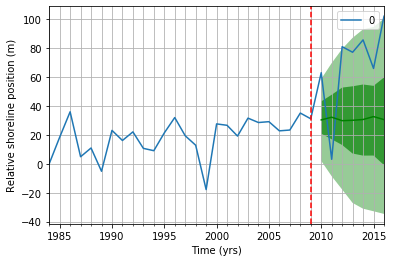

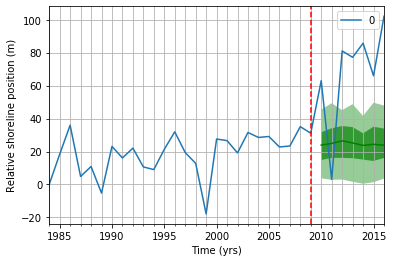

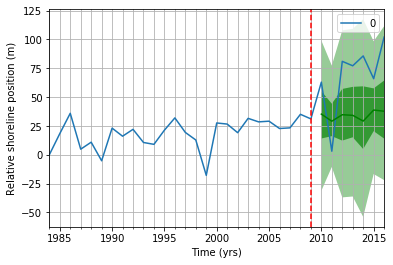

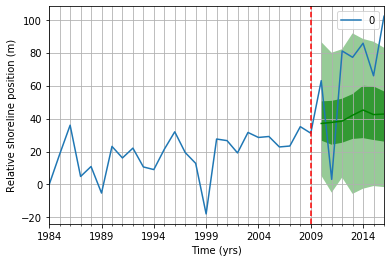

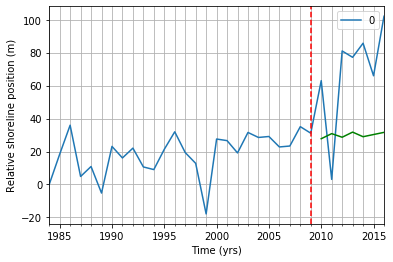

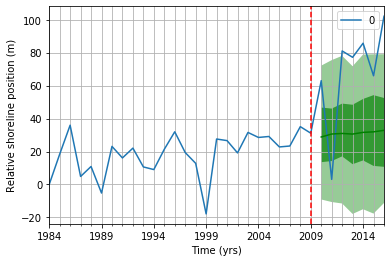

In [14]:
def plot_prob_forecast(ax, ts, fcst):
    prediction_intervals = (50.0, 90.0)
    ts.plot(ax=ax, label=fcst.item_id) 
    fcst.plot(
        prediction_intervals=prediction_intervals,
        color='g'
    ) 
    ax.axvline(x=ts.index[-(len(fcst.median)+1)], color='red', linestyle='--')
    ax.set_ylabel('Relative shoreline position (m)')
    ax.set_xlabel('Time (yrs)')
    ax.grid(which="both")
    return ax


for i in [arima_it, ets_it, simpleffn_it, deepar_it, mqcnn_it, deepssm_it]:
    fig, ax = plt.subplots()
    plot_prob_forecast(ax, next(i[1]), next(i[0]))
    plt.show()


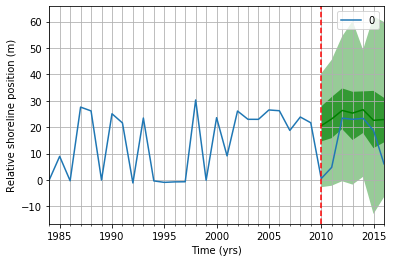

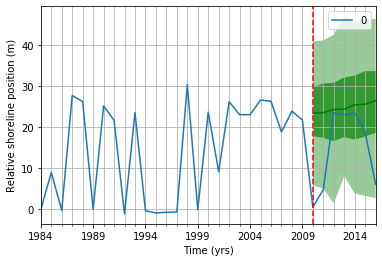

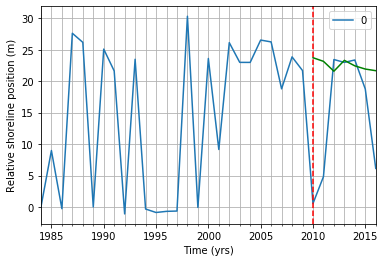

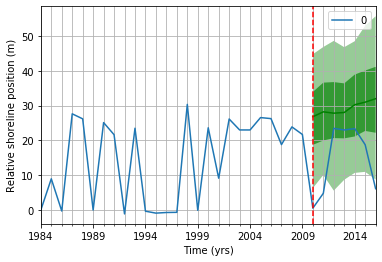

In [36]:
idx_ = np.random.choice(range(1000))


fig, ax = plt.subplots()
plot_prob_forecast(ax, tss[0][idx_], forecasts[0][idx_])
plt.show()

fig, ax = plt.subplots()
plot_prob_forecast(ax, tss[1][idx_], forecasts[1][idx_])
plt.show()

fig, ax = plt.subplots()
plot_prob_forecast(ax, tss[2][idx_], forecasts[2][idx_])
plt.show()

fig, ax = plt.subplots()
plot_prob_forecast(ax, tss[3][idx_], forecasts[3][idx_])
plt.show()


In [12]:
tr_ds, te_ds = get_gluon_ds(tf_t)

In [13]:
from scipy import stats

from shorelineforecasting.utils.forecasting_metrics import evaluate, evaluate_ 
# from utils import get_predictor_id

y = lambda intercept, slope, x: intercept + slope * x

def lr(obs, forecast=False):
    x = range(len(obs))
    slope, intercept, _, _, _ = stats.linregress(x, obs)
    if forecast is True:
        x = range(len(obs) + metadata["prediction_length"])
    return [y(intercept, slope, x) for x in x]

def make_evaluation_predictions_lr(dataset, metrics: list):
    dataset = dataset.list_data
    results = []
    for i in dataset:
        fcast = lr(i["target"][:-metadata["prediction_length"]], forecast=True)
        eval_dict = evaluate_(time_series = i["target"], 
                             predicted = fcast[-metadata["prediction_length"]:], 
                             metrics = metrics)
        eval_dict["item_id"] = i["item_id"]
        results.append(eval_dict)
    return results

results = make_evaluation_predictions_lr(te_ds, metrics=["MSE", "abs_error", "abs_target_sum", "abs_target_mean", 
                                                         "seasonal_error", "MASE", "MAPE", "sMAPE"])
lr_metrics = pd.DataFrame(results)


In [23]:
lr_metrics['predictor'] = 'linregress'
lr_metrics['predictor_id'] = 470

In [39]:
lr_metrics.loc[lr_metrics['item_id']=='BOX_160_001_9']

,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,item_id,predictor,predictor_id
11360,240.782969,96.536026,184.85651,26.408073,11.957978,1.153277,0.784777,0.477127,BOX_160_001_9,linregress,470
